In [1]:
import pandas as pd
import pandana as pdna
import time
import os
import json
import urllib
from shapely.geometry import Point, shape

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

In [2]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [3]:
city='Hamburg'

Get the geographical bounds for the city and the feed for the city's GTFS data

In [4]:
lng_min, lat_min, lng_max, lat_max = 9.965, 53.509, 10.05, 53.55
bbox=(lng_min, lat_min, lng_max, lat_max)

In [5]:
feeds.add_feed(add_dict={'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'})

Added 1 feeds to gtfs_feeds: {'Hamburg': 'http://daten.transparenz.hamburg.de/Dataport.HmbTG.ZS.Webservice.GetRessource100/GetRessource100.svc/32aedec8-c69f-4053-a5e8-9b1267eb25de/Upload__HVV_Rohdaten_GTFS_Fpl_20190207.zip'}


Download GFTS data

In [6]:
os.chdir('./'+city)

In [7]:
gtfsfeeds.download()

1 GTFS feeds will be downloaded here: data/gtfsfeed_zips
Hamburg GTFS feed downloaded successfully. Took 88.69 seconds for 29,303,447.0KB
GTFS feed download completed. Took 88.70 seconds
Hamburg.zip successfully extracted to: data/gtfsfeed_text/Hamburg
GTFS feed zipfile extraction completed. Took 3.12 seconds for 1 files


Load GTFS data into an UrbanAccess transit data object

In [8]:
validation = True
verbose = True
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file header whitespace check completed. Took 3.76 seconds
--------------------------------
Processing GTFS feed: Hamburg
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 36.76 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
Records: {}
              stop_id  stop_code                               stop_name  \
1        000000010001        NaN                        HBF/Steintorwall   
2        000000010002        NaN                        Hauptbahnhof/ZOB   
3        000000010004        NaN          U S Berliner Tor (Bürgerweide)   
4        000000010005        NaN                       Borgfelder Straße   
5        000000010006        NaN                            U Burgstraße   
6        000000010007        NaN                                  Saling   
7        000000010008        NaN                  Beim Hammer Mar

Hamburg GTFS feed stops: coordinates are in northeast hemisphere. Latitude = North (90); Longitude = East (90).
Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.27 seconds
1 GTFS feed file(s) successfully read as dataframes:
     Hamburg
     Took 47.56 seconds


Quickly view the transit stop locations

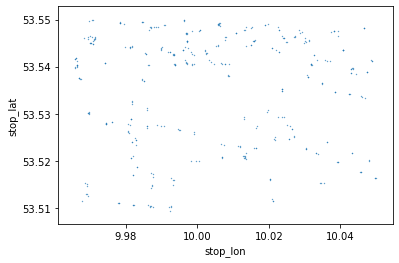

In [9]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

Create a travel time weighted graph for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period

In [10]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
235 service_ids were extracted from calendar
36,268 trip(s) 48.76 percent of 74,378 total trip records were found in calendar for GTFS feed(s): ['hamburg']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
36,268 of 74,378 total trips were extracted representing calendar day: monday. Took 0.19 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 1.99 seconds
Stop times from 07:00:00 to 10:00:00 successfully selec

Create a reference to the global network object called `urbanaccess_net`

In [11]:
urbanaccess_net = ua.network.ua_network

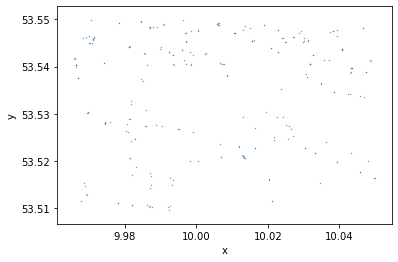

In [12]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

# Download OSM data

In [13]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](53.50900000,9.96500000,53.55000000,10.05000000);>;);out;'}"
Downloaded 4,889.0KB from www.overpass-api.de in 17.01 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 17.26 seconds
Returning OSM data with 29,879 nodes and 8,017 ways...
Edge node pairs completed. Took 35.59 seconds
Returning processed graph with 9,739 nodes and 28,920 edges...
Completed OSM data download and Pandana node and edge table creation in 54.87 seconds
checking for low connectivity nodes...
48 out of 9,739 nodes (0.49 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table creation in 8

Create a travel time weighted graph from the pedestrian network - assume a pedestrian travels on average at 3 mph.
The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

In [14]:
remove_link_types=[
 'bridleway',
 'services',
 'steps',
 'footway',
 'cycleway',
 'service',
 'traffic_island',
 'unclassified',
 'track',
 'path'
]

In [15]:
edges=edges.loc[~edges['highway'].isin(remove_link_types)]
all_nodes_included=set(list(edges['from'].values)+list(edges['to'].values))
nodes=nodes.loc[nodes['id'].isin(all_nodes_included)]

In [16]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


In [17]:
urbanaccess_net.osm_nodes.head()

,x,y,id,net_type
id,,,,
122324,10.024134,53.529239,122324,walk
122329,10.031002,53.537496,122329,walk
122332,10.032257,53.539048,122332,walk
122349,9.985260,53.547938,122349,walk
122351,9.977550,53.549309,122351,walk


In [18]:
urbanaccess_net.osm_edges.head()

access area bridge    distance        from  hgv  \
14571733   1067869881    NaN  NaN    NaN   50.957920    14571733  NaN   
1067869881 14571733      NaN  NaN    NaN   50.957920  1067869881  NaN   
           6295526362    NaN  NaN    NaN    6.177336  1067869881  NaN   
6295526362 1067869881    NaN  NaN    NaN    6.177336  6295526362  NaN   
           534744747     NaN  NaN    NaN  102.327393  6295526362  NaN   

                         highway junction lanes maxspeed               name  \
14571733   1067869881  secondary      NaN   NaN       50  Hammerbrookstraße   
1067869881 14571733    secondary      NaN   NaN       50  Hammerbrookstraße   
           6295526362  secondary      NaN   NaN       50  Hammerbrookstraße   
6295526362 1067869881  secondary      NaN   NaN       50  Hammerbrookstraße   
           534744747   secondary      NaN   NaN       50  Hammerbrookstraße   

                      oneway  ref service          to toll tunnel width  \
14571733   1067869881    NaN  NaN     NaN  1067869881  NaN    NaN   NaN   
1067869881 14571733      NaN  NaN     NaN    14571733  NaN    NaN   NaN   
           6295526362    NaN  NaN     NaN  6295526362  NaN    NaN   NaN   
6295526362 1067869881    NaN  NaN     NaN  1067869881  NaN    NaN   NaN   
           534744747     NaN  NaN     NaN   534744747  NaN    NaN   NaN   

                         weight net_type  
14571733   1067869881  0.633277     walk  
1067869881 14571733    0.633277     walk  
           6295526362  0.076769     walk  
6295526362 1067869881  0.076769     walk  
           534744747   1.271669     walk

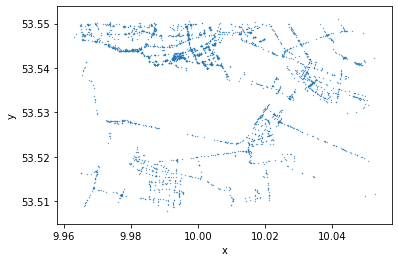

In [19]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

Add average transit headways

In [20]:
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 4,272 records out of 23,493 total records (18.18 percent of total). Took 0.00 seconds
Starting route stop headway calculation for 361 route stops...
Route stop headway calculation complete. Took 2.01 seconds
headway calculation complete. Took 2.38 seconds


In [21]:
loaded_feeds.headways.head()

,count,mean,std,min,25%,50%,75%,max,unique_stop_id,unique_route_id,node_id_route
2077,8.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,000000100007_hamburger_verkehrsverbund_(hvv),1301_3_hamburger_verkehrsverbund_(hvv),000000100007_hamburger_verkehrsverbund_(hvv)_1...
2087,8.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,000000100007_hamburger_verkehrsverbund_(hvv),1301_3_hamburger_verkehrsverbund_(hvv),000000100007_hamburger_verkehrsverbund_(hvv)_1...
2097,8.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,000000100007_hamburger_verkehrsverbund_(hvv),1301_3_hamburger_verkehrsverbund_(hvv),000000100007_hamburger_verkehrsverbund_(hvv)_1...
2107,8.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,000000100007_hamburger_verkehrsverbund_(hvv),1301_3_hamburger_verkehrsverbund_(hvv),000000100007_hamburger_verkehrsverbund_(hvv)_1...
2117,8.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,000000100007_hamburger_verkehrsverbund_(hvv),1301_3_hamburger_verkehrsverbund_(hvv),000000100007_hamburger_verkehrsverbund_(hvv)_1...


In [22]:
# Not using the headways
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 251 nodes and 3,234 edges;
     OSM: 3,041 nodes and 7,048 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 0.31 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 0.21 seconds
Network edge and node network integration completed successfully resulting in a total of 3,292 nodes and 10,784 edges:
     Transit: 251 nodes 3,234 edges;
     OSM: 3,041 nodes 7,048 edges; and
     OSM/Transit connector: 502 edges.


# Create an integrated transit and pedestrian network

In [23]:
urbanaccess_net.net_nodes.head()

,id,location_type,net_type,parent_station,route_type,stop_code,stop_id,stop_name,unique_agency_id,wheelchair_boarding,x,y
id_int,,,,,,,,,,,,
1,000000100033_hamburger_verkehrsverbund_(hvv),0.0,transit,000000010024,3.0,NaN,000000100033,U Steinstraße,hamburger_verkehrsverbund_(hvv),NaN,10.005876,53.549037
2,000000100034_hamburger_verkehrsverbund_(hvv),0.0,transit,000000010023,3.0,NaN,000000100034,Spaldingstraße,hamburger_verkehrsverbund_(hvv),NaN,10.010795,53.547135
3,000000100035_hamburger_verkehrsverbund_(hvv),0.0,transit,000000010022,3.0,NaN,000000100035,Lippeltstraße,hamburger_verkehrsverbund_(hvv),NaN,10.015734,53.545485
4,000000100036_hamburger_verkehrsverbund_(hvv),0.0,transit,000000010021,3.0,NaN,000000100036,Nagelsweg,hamburger_verkehrsverbund_(hvv),NaN,10.022963,53.543105
5,000000100047_hamburger_verkehrsverbund_(hvv),0.0,transit,000000010021,3.0,NaN,000000100047,Nagelsweg,hamburger_verkehrsverbund_(hvv),NaN,10.020993,53.543966


In [24]:
urbanaccess_net.net_edges.head()

,access,area,bridge,distance,from,hgv,highway,edge_id,junction,lanes,...,to,toll,tunnel,unique_agency_id,unique_route_id,unique_trip_id,weight,width,from_int,to_int
0,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336647_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336647_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
1,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336906_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336906_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
2,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336907_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336907_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
3,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336908_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336908_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
4,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336909_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336909_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149


In [25]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

,access,area,bridge,distance,from,hgv,highway,edge_id,junction,lanes,...,to,toll,tunnel,unique_agency_id,unique_route_id,unique_trip_id,weight,width,from_int,to_int
0,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336647_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336647_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
1,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336906_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336906_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
2,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336907_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336907_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
3,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336908_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336908_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149
4,nan,nan,nan,NaN,090000109018_hamburger_verkehrsverbund_(hvv),nan,nan,17336909_hamburger_verkehrsverbund_(hvv)_1,nan,nan,...,090000119007_hamburger_verkehrsverbund_(hvv),nan,nan,hamburger_verkehrsverbund_(hvv),1466_1_hamburger_verkehrsverbund_(hvv),17336909_hamburger_verkehrsverbund_(hvv),1.0,nan,146,149


Plot the combined network

In [26]:
edgecolor_weight = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)

In [27]:
edgecolor_type=list(urbanaccess_net.net_edges.apply(lambda row: (1,0,0,1) if row['net_type']=='transit' else (127/255,201/255,127/255, 1), axis=1))

Plot by link type

Figure created. Took 2.63 seconds


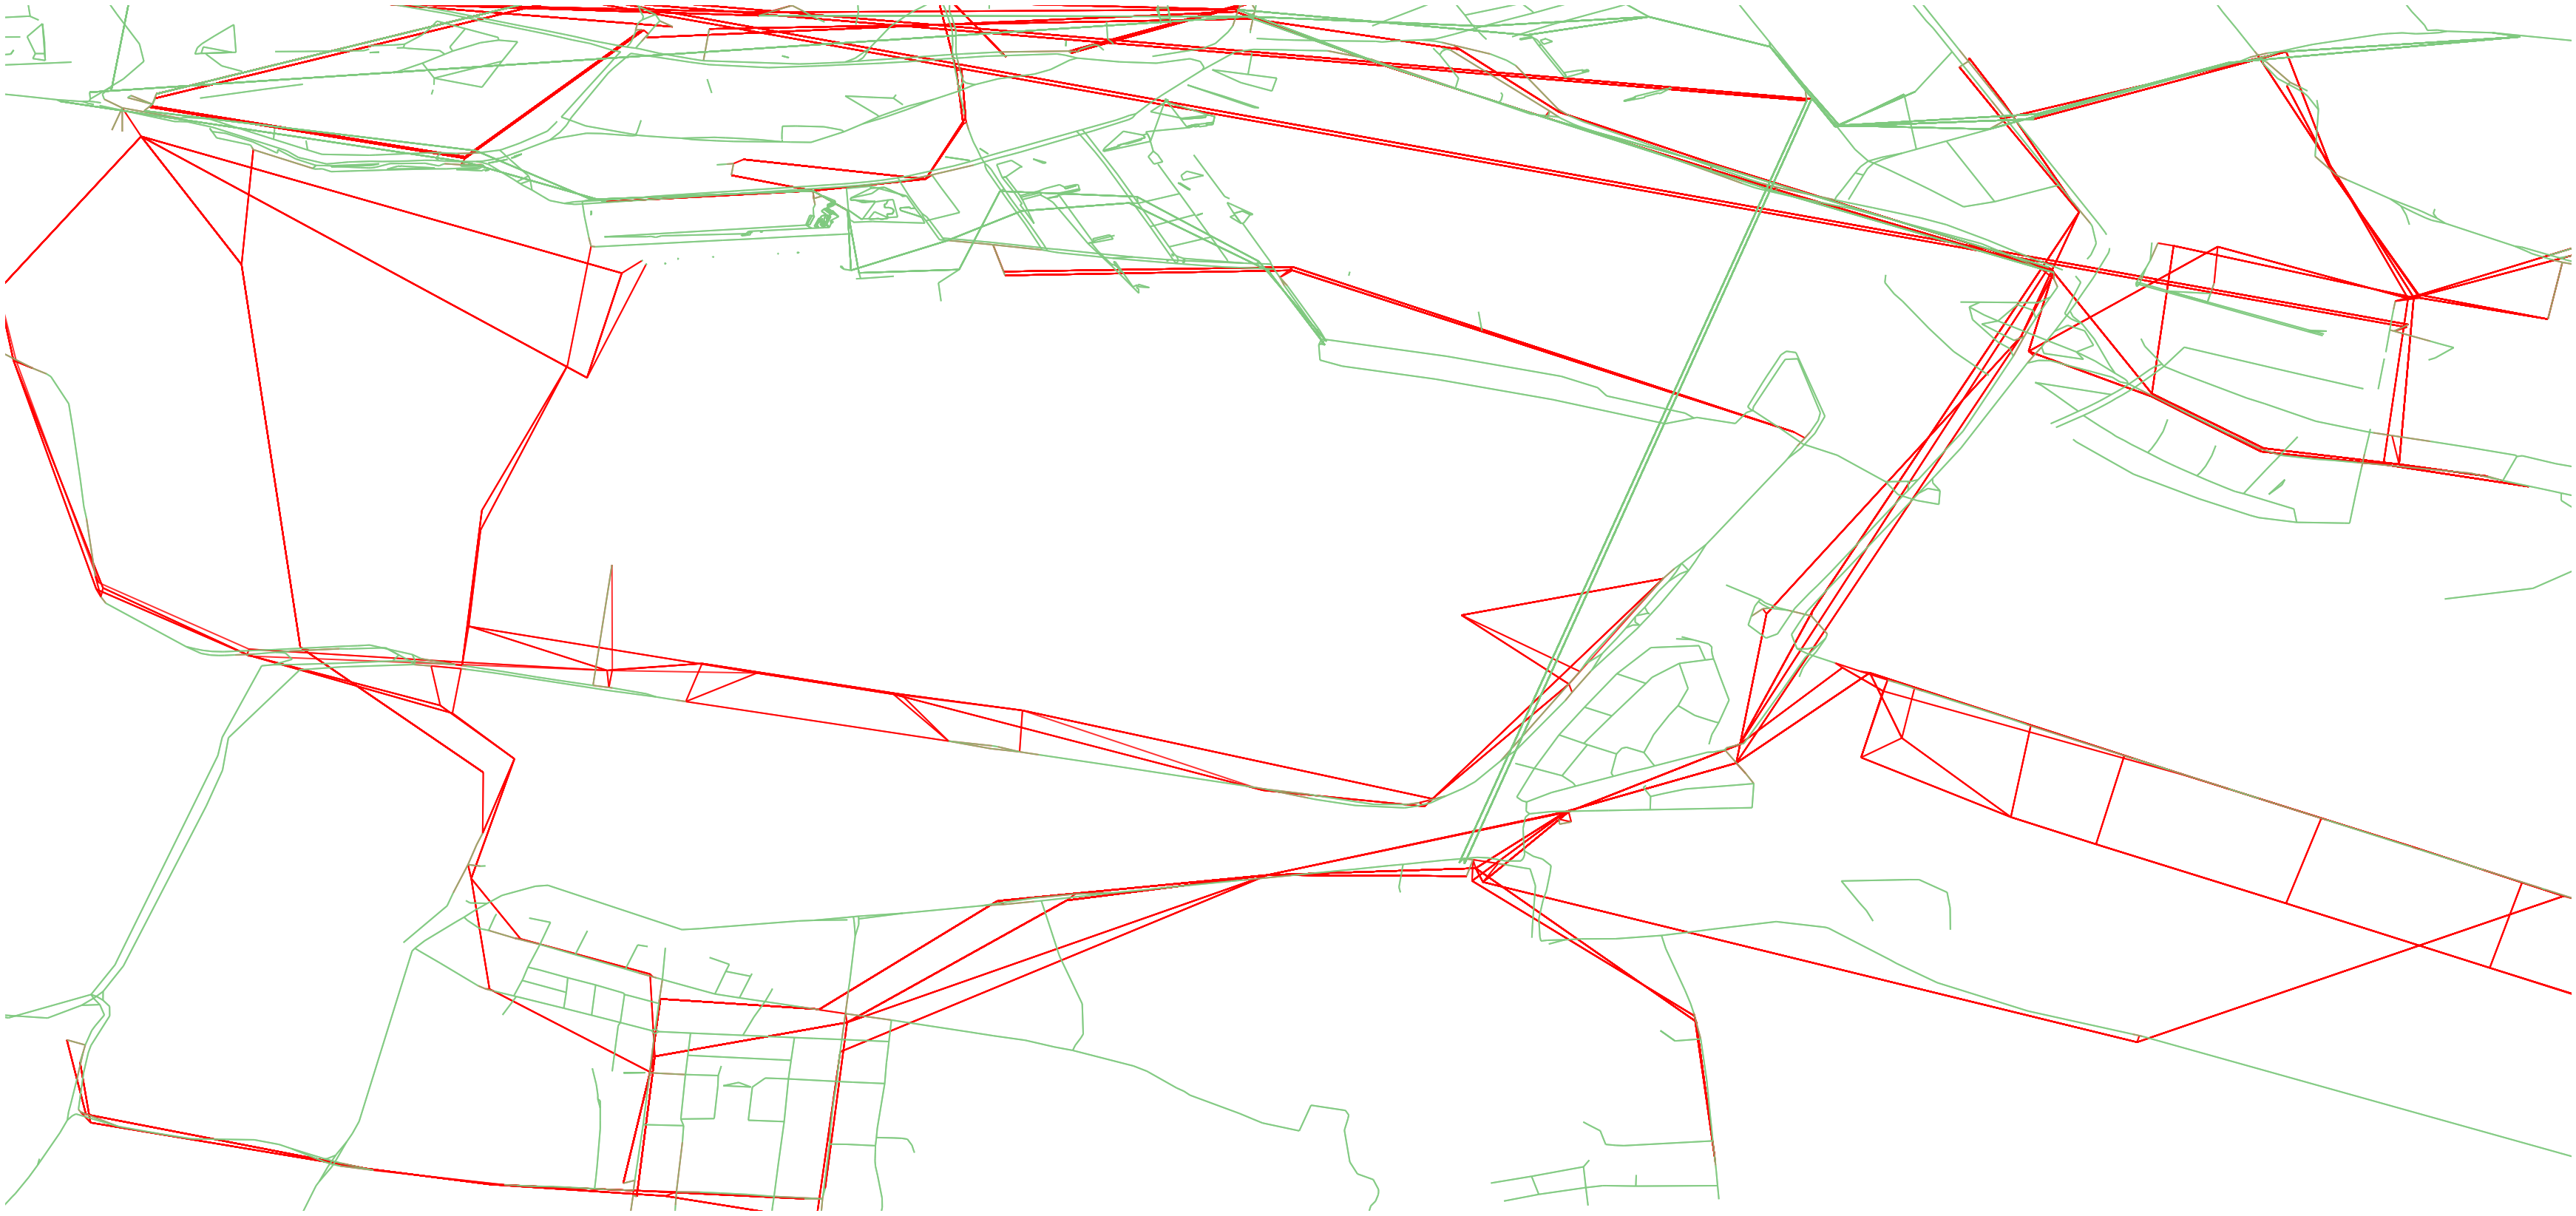

(<Figure size 4478.05x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137245748>)

In [28]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_type, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Figure created. Took 4.06 seconds


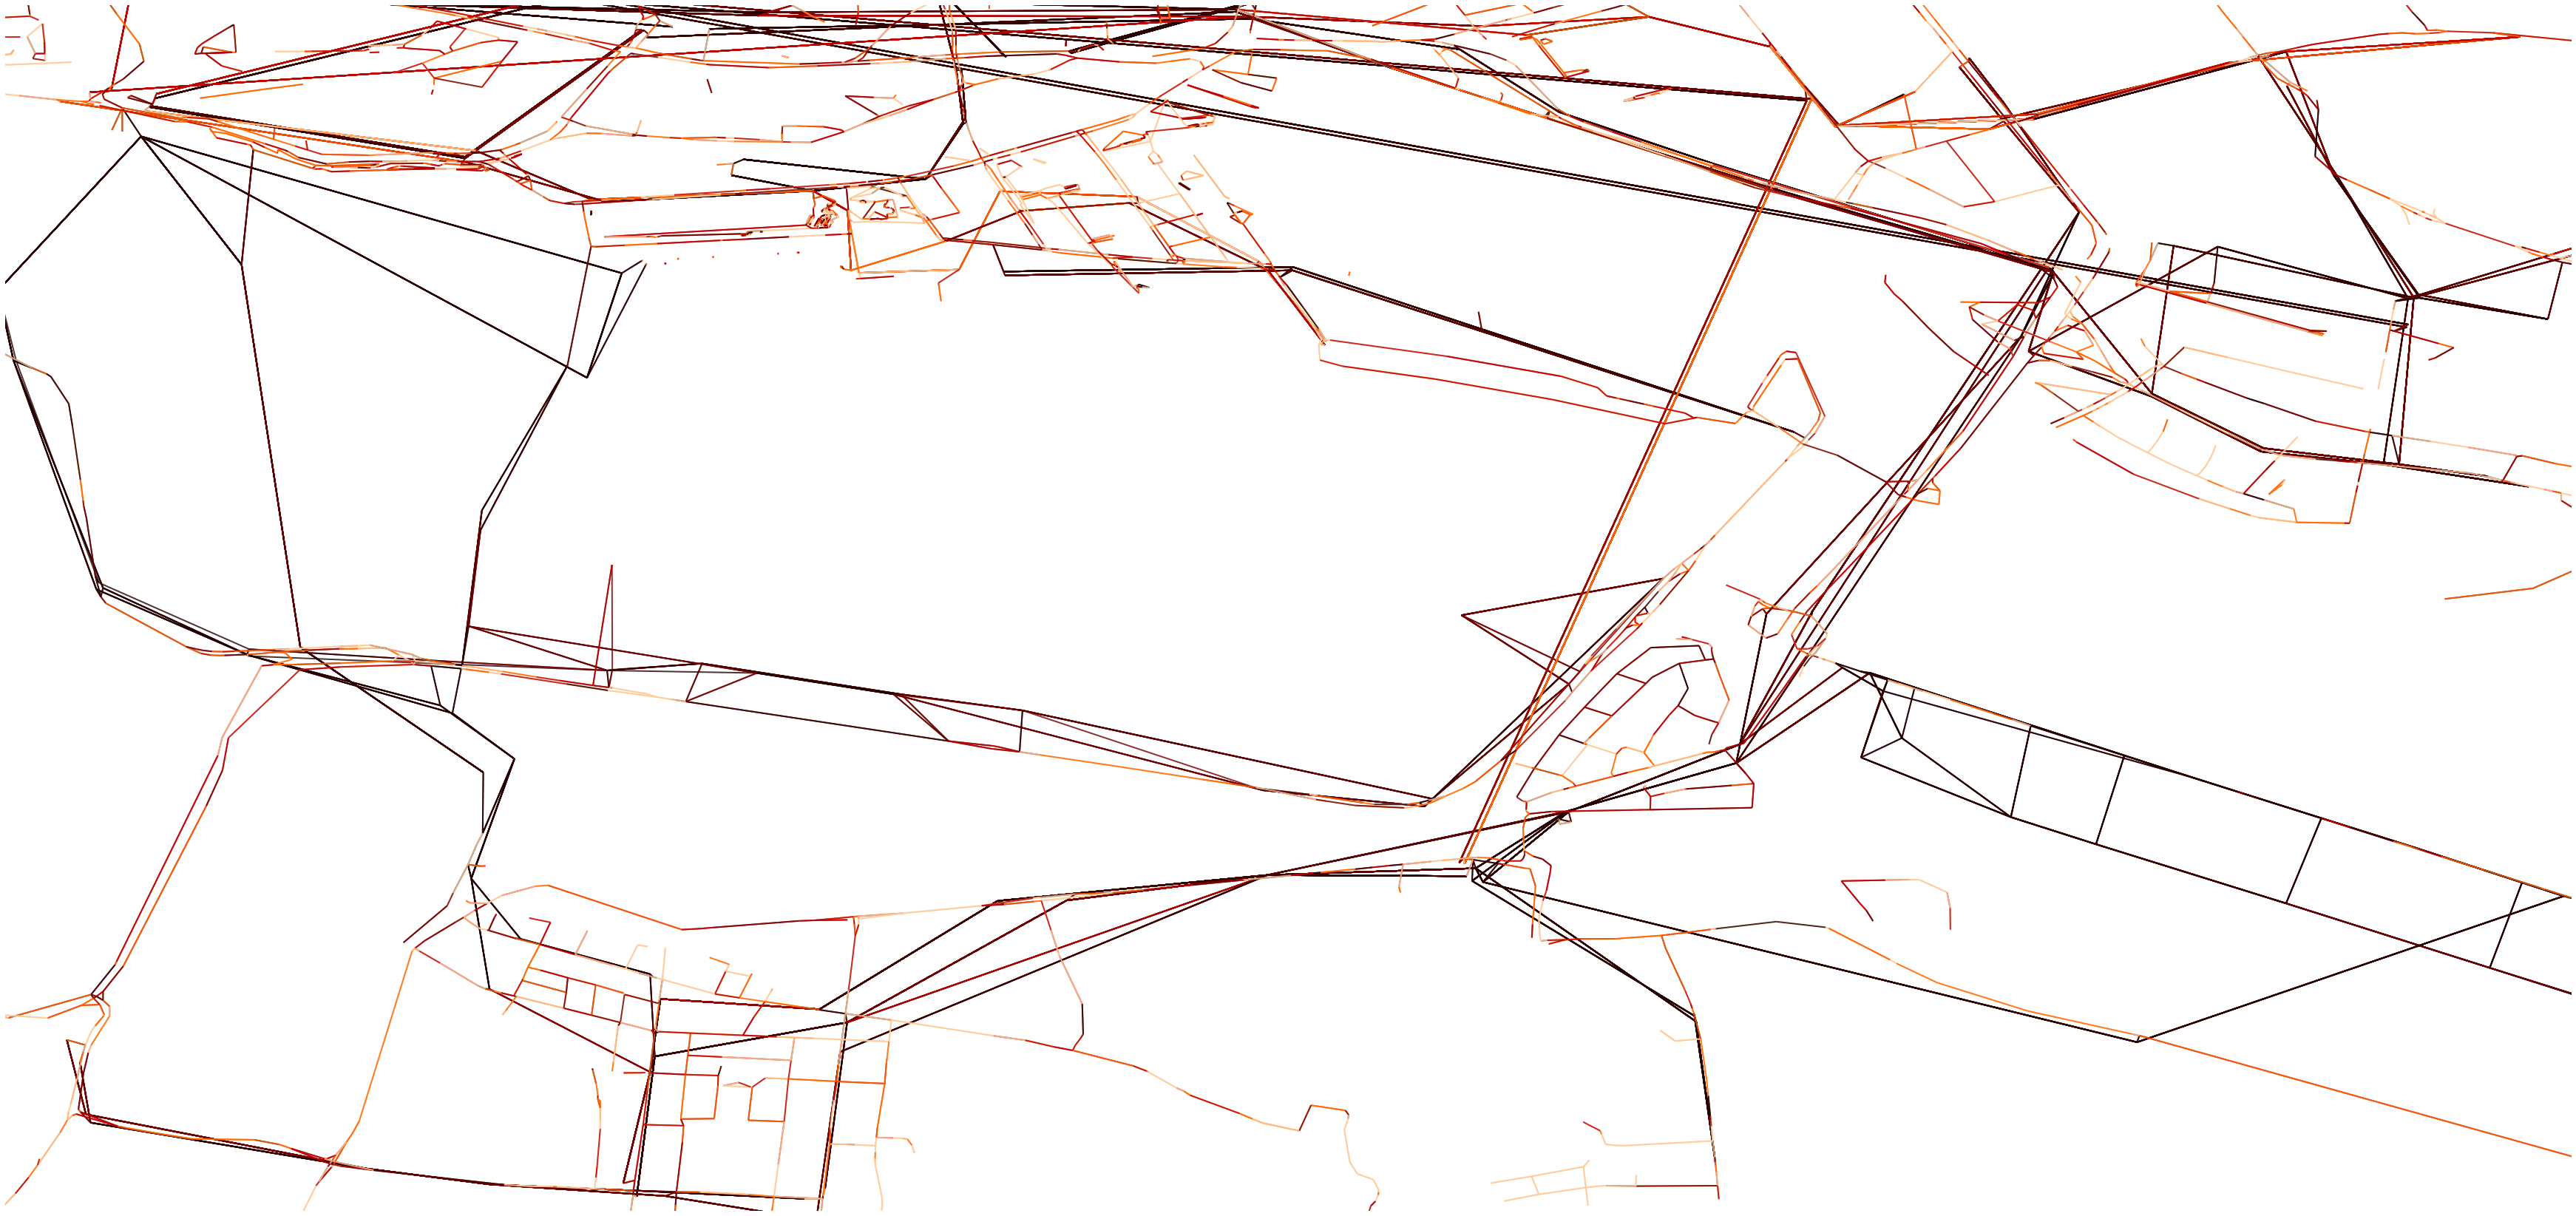

(<Figure size 4478.05x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14dfe65f8>)

In [29]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_weight, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Save the combined network as csv

# Using an UrbanAccess network with Pandana

- set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- `node ids` and `from` and `to` columns in your network must be integer type and not string. 
- edge weights represent travel time in minutes.

## Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [30]:
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 0.33 seconds


In [31]:
s_time = time.time()
transit_ped_net.precompute(20)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 0.42 seconds


Save the pandana network (just the network, no associated data)

In [32]:
transit_ped_net.save_hdf5('./data/comb_network.hdf5')

In [33]:
net=pdna.Network.from_hdf5('./data/comb_network.hdf5')